In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
odiac = pd.read_csv(Path.cwd()/'../preprocessing/data2/clean/odiac_monthly.csv')
xco2 = pd.read_csv(Path.cwd()/'../preprocessing/data2/clean/oco2_lvl2_xco2_monthly.csv')

In [4]:
odiac[(odiac['Latitude'] == 35.5) & (odiac['Longitude'] == -24.5) & (odiac['Month'] == 1) & (odiac['Year'] == 2016)]

,Latitude,Longitude,Emissions,Month,Year
0,35.5,-24.5,0.0,1,2016


In [5]:
xco2[(xco2['Latitude'] == 35.5) & (xco2['Longitude'] == -24.5) & (xco2['Month'] == 1) & (xco2['Year'] == 2016)]

,Longitude,Latitude,Month,Year,xco2,xco2_anomaly,geometry
1,-24.5,35.5,1.0,2016.0,398.776052,-37.04658,POINT (-24.5 35.5)


In [6]:
data = pd.merge(odiac, xco2, how='left', on=['Longitude', 'Latitude', 'Month', 'Year'])
data = data.sort_values(by=['Year', 'Month', 'Longitude', 'Latitude'])
data

,Latitude,Longitude,Emissions,Month,Year,xco2,xco2_anomaly,geometry
159840,35.5,-24.5,0.000000,1,2015,398.437805,0.180817,POINT (-24.5 35.5)
159852,36.5,-24.5,0.000000,1,2015,398.850555,0.593567,POINT (-24.5 36.5)
159864,37.5,-24.5,0.000000,1,2015,396.721029,-47.294352,POINT (-24.5 37.5)
159876,38.5,-24.5,0.000000,1,2015,393.097565,-5.386536,POINT (-24.5 38.5)
159888,39.5,-24.5,0.000000,1,2015,396.571869,-1.912231,POINT (-24.5 39.5)
...,...,...,...,...,...,...,...,...
159791,67.5,64.5,0.301591,12,2019,401.264201,-98.678945,POINT (64.5 67.5)
159803,68.5,64.5,0.000000,12,2019,397.068766,-102.874379,POINT (64.5 68.5)
159815,69.5,64.5,0.000337,12,2019,394.516693,-105.426453,POINT (64.5 69.5)
159827,70.5,64.5,0.000000,12,2019,399.343913,-100.599233,POINT (64.5 70.5)


In [7]:
X = data[['Latitude', 'Longitude', 'xco2', 'xco2_anomaly', 'Month', 'Year']]
y = data['Emissions']

In [8]:
y

159840    0.000000
159852    0.000000
159864    0.000000
159876    0.000000
159888    0.000000
            ...   
159791    0.301591
159803    0.000000
159815    0.000337
159827    0.000000
159839    0.000000
Name: Emissions, Length: 199800, dtype: float64

In [9]:
X_train, X_test = X[X['Year'] < 2019], X[X['Year'] == 2019]
y_train, y_test = y[X['Year'] < 2019], y[X['Year'] == 2019]

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

gbr = GradientBoostingRegressor(random_state=0)

gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

mean_absolute_error(y_test,y_pred)

0.16281178548443528

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mean_absolute_error(y_test,y_pred)

0.011377260982453452

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [50, 100, 150, 250],
    'max_depth' : [5, 8, 15, None],
}
rf = RandomForestRegressor(random_state=0)
cv_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    )
cv_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 8, 15, None],
                         'n_estimators': [50, 100, 150, 250]},
             scoring='neg_mean_squared_error')

In [13]:
cv_rf.best_estimator_

RandomForestRegressor(n_estimators=250, random_state=0)

In [14]:
cv_rf.best_score_

-0.0013587578342512438

In [15]:
res = cv_rf.cv_results_

In [16]:
rf = RandomForestRegressor(n_estimators=250, random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mean_absolute_error(y_test,y_pred)

0.011308460559738956

In [35]:
scores = pd.concat([pd.DataFrame(cv_rf.cv_results_['params']),pd.DataFrame(-np.round(cv_rf.cv_results_['mean_test_score'], 6), columns=['MAE'])],axis=1)
scores.sort_values(by=['MAE']).to_csv(Path.cwd()/'random_forest_scores.csv')

In [ ]:
s

In [18]:
# import pickle



# with open('rf.pkl','wb') as f:
#     pickle.dump(rf,f)


In [19]:
preds = pd.merge(X_test.reset_index(drop=True), pd.Series(y_pred, name='Emissions'), left_index=True, right_index=True)

In [20]:
preds['Emissions_true'] = y_test.reset_index(drop=True)

In [21]:
preds['diff'] = np.abs(preds['Emissions'] - preds['Emissions_true'])

In [22]:
preds

,Latitude,Longitude,xco2,xco2_anomaly,Month,Year,Emissions,Emissions_true,diff
0,35.5,-24.5,405.708740,-16.018646,1,2019,0.000000,0.000000,0.000000
1,36.5,-24.5,410.195587,-11.531799,1,2019,0.000000,0.000000,0.000000
2,37.5,-24.5,410.415741,-11.311646,1,2019,0.000000,0.000000,0.000000
3,38.5,-24.5,409.752808,-11.974579,1,2019,0.000000,0.000000,0.000000
4,39.5,-24.5,406.681864,-49.221883,1,2019,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
39955,67.5,64.5,401.264201,-98.678945,12,2019,0.285829,0.301591,0.015762
39956,68.5,64.5,397.068766,-102.874379,12,2019,0.000000,0.000000,0.000000
39957,69.5,64.5,394.516693,-105.426453,12,2019,0.000360,0.000337,0.000023
39958,70.5,64.5,399.343913,-100.599233,12,2019,0.000060,0.000000,0.000060


In [23]:
import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, box
gdf = gpd.GeoDataFrame(
    preds, geometry=gpd.points_from_xy(x=preds.Longitude, y=preds.Latitude)
)

In [24]:
gdf

,Latitude,Longitude,xco2,xco2_anomaly,Month,Year,Emissions,Emissions_true,diff,geometry
0,35.5,-24.5,405.708740,-16.018646,1,2019,0.000000,0.000000,0.000000,POINT (-24.50000 35.50000)
1,36.5,-24.5,410.195587,-11.531799,1,2019,0.000000,0.000000,0.000000,POINT (-24.50000 36.50000)
2,37.5,-24.5,410.415741,-11.311646,1,2019,0.000000,0.000000,0.000000,POINT (-24.50000 37.50000)
3,38.5,-24.5,409.752808,-11.974579,1,2019,0.000000,0.000000,0.000000,POINT (-24.50000 38.50000)
4,39.5,-24.5,406.681864,-49.221883,1,2019,0.000000,0.000000,0.000000,POINT (-24.50000 39.50000)
...,...,...,...,...,...,...,...,...,...,...
39955,67.5,64.5,401.264201,-98.678945,12,2019,0.285829,0.301591,0.015762,POINT (64.50000 67.50000)
39956,68.5,64.5,397.068766,-102.874379,12,2019,0.000000,0.000000,0.000000,POINT (64.50000 68.50000)
39957,69.5,64.5,394.516693,-105.426453,12,2019,0.000360,0.000337,0.000023,POINT (64.50000 69.50000)
39958,70.5,64.5,399.343913,-100.599233,12,2019,0.000060,0.000000,0.000060,POINT (64.50000 70.50000)


In [25]:
def plot_emission_map(gdf: gpd.GeoDataFrame, year: int, month: int, quantiles: int):
    fig_size = (12,5)
    fig, ax = plt.subplots(figsize = fig_size)

    world_filepath = gpd.datasets.get_path('naturalearth_lowres')
    world = gpd.read_file(world_filepath)
    europe = gpd.clip(world, box(-25, 35, 65, 72))
    europe.boundary.plot(
        figsize=fig_size,
        ax=ax,
        color='black'
    )
    
    gdf[(gdf.Year == year) & (gdf.Month == month)].plot(
        'Emissions', 
        ax=ax,
        scheme='quantiles', 
        k=quantiles, 
        figsize=fig_size,
        marker='s',
        markersize=40,
        legend=True, legend_kwds={'bbox_to_anchor': (1, 1)}
    )
    plt.axis('off')
    plt.show()

In [26]:
def plot_emission_diff_map(gdf: gpd.GeoDataFrame, year: int, month: int):
    fig_size = (12,5)
    fig, ax = plt.subplots(figsize = fig_size)

    world_filepath = gpd.datasets.get_path('naturalearth_lowres')
    world = gpd.read_file(world_filepath)
    europe = gpd.clip(world, box(-25, 35, 65, 72))
    europe.boundary.plot(
        figsize=fig_size,
        ax=ax,
        color='black'
    )
    gdf[(gdf.Year == year) & (gdf.Month == month)].plot(
        'diff', 
        ax=ax,
        figsize=fig_size,
        marker='s',
        markersize=40,
        legend=True
    )
    plt.axis('off')
    plt.show()

/Users/timurkambachekov/opt/anaconda3/envs/geo_base/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/timurkambachekov/opt/anaconda3/envs/geo_base/lib/python3.11/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 8.
  warnings.warn(


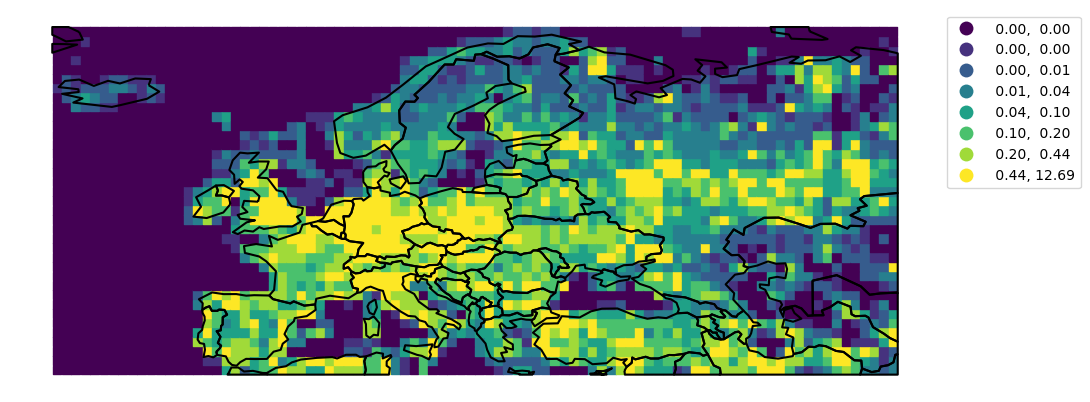

In [27]:
plot_emission_map(gdf, 2019, 5, quantiles=10)

/Users/timurkambachekov/opt/anaconda3/envs/geo_base/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


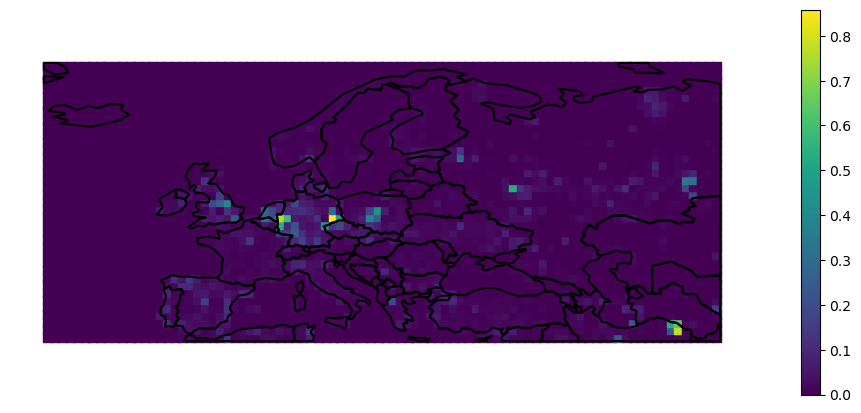

In [28]:
plot_emission_diff_map(gdf, 2019, 1)